In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Autosaving every 180 seconds


In [2]:
import importlib
import sys
sys.path.append('../../')
import src
importlib.reload(src)

<module 'src' (namespace)>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import numpy as np
from scipy.io import loadmat, savemat
import src.plot_utils as plot_utils
import src.ml_utils as ml_utils
import src.eikonal as eikonal
import src.openst.OpenST as ost
from tqdm.notebook import tqdm
import datetime

Using TensorFlow backend.


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras.constraints import NonNeg, MinMaxNorm
from IPython.display import clear_output

In [5]:
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.utils import plot_model

In [6]:
MODEL, outs = eikonal.forward_model(nh=50, layers=3, shape=(1,), activation='tanh', act_constraints=None, lr=5e-4, decay=0,
                               init='glorot_normal', Blambda=1.0, Mlambda=0.0, Llambda=0.0, Plambda=1.0, monotonity_dxy=False, 
                               inversion=False)

## Analytic solution for vertical gradient

In [8]:
nx, nz = 51, 51
xmin, xmax = 0, 1000
zmin, zmax = 0, 1000
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
dx, dz = x[1] - x[0], z[1] - z[0]
X, Z = np.meshgrid(x, z, indexing='ij')

vmin, vmax = 1000.0, 4000.0
a = (vmax - vmin) / z.max()

In [9]:
ixs, izs = 25, 25
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
sou_xz = np.array(sou, ndmin=2)

wmax, wmin = 2.0, 0.1
wsigma = (max(xmax, zmax) - min(xmin,zmin)) / 4
sample_weights = (wmax - wmin) * np.exp(- (X - xs)**2/2/wsigma**2 - (Z - zs)**2/2/wsigma**2) + wmin

sigm_x = max(abs(x - xs)) / 2.5
sigm_z = max(abs(z - zs)) / 2.5
cov = np.diag([sigm_x**2, sigm_z**2])
XZ_r = np.random.multivariate_normal(sou, cov, nx*nz)
X_r, Z_r = XZ_r.T
XZ_r = XZ_r[(X_r < xmax) * (X_r > xmin) * (Z_r < zmax) * (Z_r > zmin)]
XZ_r = np.concatenate((XZ_r, sou_xz), axis=0)
X_r, Z_r = XZ_r.T
XZ_r_shift = XZ_r - sou_xz
X_r_shift, Z_r_shift = XZ_r_shift.T
X_r_scaled, Z_r_scaled = X_r_shift / scaler, Z_r_shift / scaler

X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler


V = eikonal.vel_func(vmin, a)(Z)
V_r = eikonal.vel_func(vmin, a)(Z_r)
V_scaled = V / V.max()
V_r_scaled = V_r / V.max()

R = np.linalg.norm(np.stack([X_scaled, Z_scaled], axis=-1), axis=-1)
R_r = np.linalg.norm(np.stack([X_r_scaled, Z_r_scaled], axis=-1), axis=-1)
B = np.full_like(R, -1.0)
B[R == 0] = 0.0
# B[ixs-1:ixs+2,izs-1:izs+2] = T[ixs-1:ixs+2,izs-1:izs+2]
B_scaled = B * V.max() / scaler
B_r = np.full_like(R_r, -1.0)
B_r[R_r == 0] = 0.0
B_r_scaled = B_r * V.max() / scaler

T = eikonal.t_vgrad(X, Z, X[ixs, izs], Z[ixs,izs], vmin, a)
T_r = eikonal.t_vgrad(X_r, Z_r, xs, zs, vmin, a)
T_homo = R / V_scaled.mean()
bound_inds = (X == X.min()) + (X == X.max()) + (Z == Z.min()) + (Z == Z.max())
B_homo = B.copy()
B_homo[bound_inds] = T_homo[bound_inds]

# B[Z == zs] = T[Z == zs] * V.max() / scaler

tau_grad = eikonal.t_vfield_vgrad(X, Z, xs, zs, vmin, a)
tau_modul = np.linalg.norm(tau_grad, axis=-1, keepdims=True) + 1e-16
tau_grad /= tau_modul

data_inhomo = eikonal.prepare_inputs([X_scaled.ravel(), Z_scaled.ravel(), V_scaled.ravel(), B_scaled.ravel(), T], 
                                     ['input_x', 'input_y', 'velocity', 'bounds', 'true'])
data_r = eikonal.prepare_inputs([X_r_scaled.ravel(), Z_r_scaled.ravel(), V_r_scaled.ravel(), B_r_scaled.ravel(), T], 
                                ['input_x', 'input_y', 'velocity', 'bounds', 'true'])

../..\src\eikonal\helpers.py:87: RuntimeWarning: divide by zero encountered in true_divide
  A = 1 / a / np.sqrt((up / down + 1)**2 - 1)
../..\src\eikonal\helpers.py:88: RuntimeWarning: invalid value encountered in multiply
  dt_dx = 2 * a**2 * Xdiff / down * A
../..\src\eikonal\helpers.py:89: RuntimeWarning: invalid value encountered in multiply
  dt_dz = (2 * a**2 * Zdiff / down - 2 * a * Vxszs * up / down**2) * A


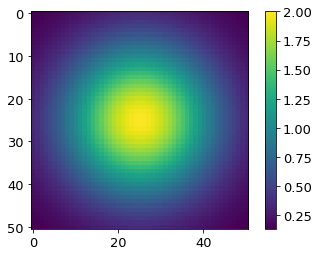

In [184]:
plt.imshow(sample_weights.T)
plt.colorbar()

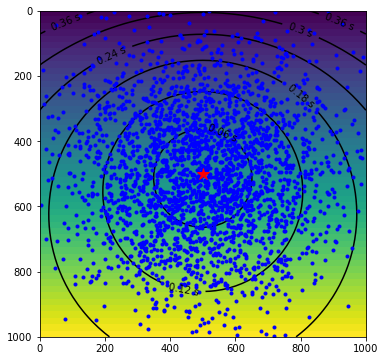

In [8]:
step = 5

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_1 = tau_grad[::step, ::step, 0]
V_1 = -tau_grad[::step, ::step, 1]

plt.figure(figsize=(6,6))

extent=(x.min(), x.max(), z.min(), z.max())

plt.imshow(V.T, extent=(xmin,xmax,zmax,zmin))
cs = plt.contour(T.T, extent=extent, colors='k')
plt.clabel(cs, cs.levels, inline=True, inline_spacing=5, fmt='%r s', fontsize=10)
plt.ylim([z.max(), z.min()])
# plt.quiver(X_, Z_, U_1, V_1, scale=20, color='k', hatch='', linestyles='-.')
plt.plot(X_r, Z_r, '.b')
plt.plot(sou[0], sou[1], 'r*', ms=12)
plt.axis('scaled')

plt.show()

## FSM solution for vertical gradient

In [12]:
%%time
CoordLimLow = np.array([xmin, zmin])
CoordLimHigh = np.array([xmax, zmax])
GridSize = np.array([nx, nz])
GridStep = (CoordLimHigh - CoordLimLow) / (GridSize - 1)

# FSM = np.empty(shape=(nx,nz,nx,nz))
# with tqdm_notebook(total=nx*nz, desc='Eikonal solving') as p_bar:
#     for ind, _ in np.ndenumerate(X):
#         SRC = np.array([X[ind], Z[ind]])
#         FSM[ind] = ost.LSM2D(V, CoordLimLow, CoordLimHigh, GridStep, SRC)
#         p_bar.update()
src = np.array([X[ixs, izs], Z[ixs, izs]])
fsm = ost.LSM2D(V, CoordLimLow, CoordLimHigh, GridStep, src)

Wall time: 0 ns


In [13]:
AE = abs(Tau - FSM)
rAE = AE / (Tau + 1e-16) * 100
MAE = AE.mean(axis=(2,3))
rMAE = rAE.mean(axis=(2,3))

plt.figure()
plt.title('{0:.2f} %'.format(rMAE.mean()))
plt.contourf(rMAE.T, extent=(xmin,xmax,zmin,zmax))
plt.ylim([zmax, zmin])
plt.colorbar(fraction=1/22)
plt.axis('scaled')
plt.show()

NameError: name 'Tau' is not defined

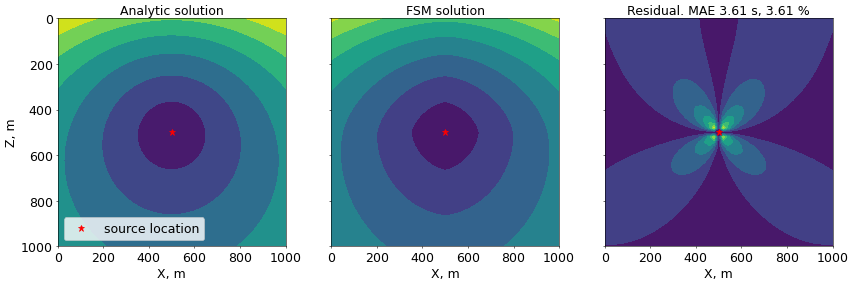

In [14]:
mae = abs(T - fsm) / (T + 1e-16) * 100

fig, axes = plot_utils.plot_images([[T.T, fsm.T, mae.T]], cols_names=[['Analytic solution', 'FSM solution', 
                'Residual. MAE {0:.2f} s, {1:.2f} %'.format(mae.mean(), mae.mean())]],
                sources=[[sou, sou, sou]], figsize=(20,15), fontsize=18, imshows=False, extent=(xmin,xmax,zmin,zmax), source_size=10)
plt.show()

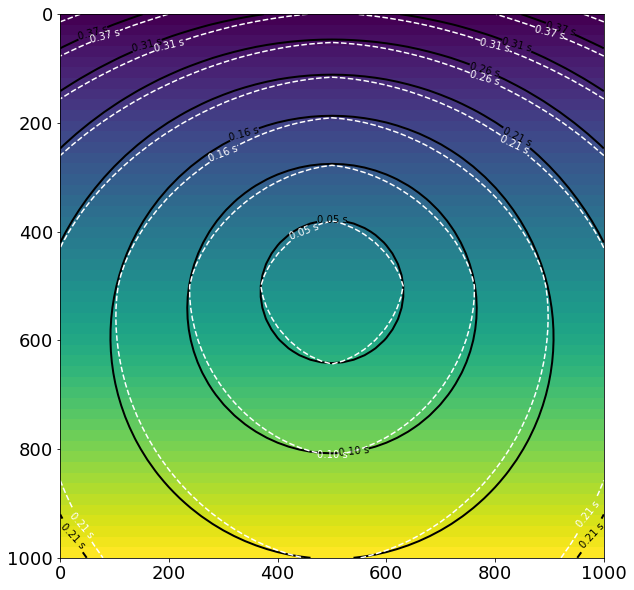

In [15]:
fsm_grad = np.array(np.gradient(fsm, dx, dz))

step = 5

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_1 = tau_grad[::step, ::step, 0]
V_1 = -tau_grad[::step, ::step, 1]
U_2 = fsm_grad[::step, ::step, 0]
V_2 = -fsm_grad[::step, ::step, 1]

plt.figure(figsize=(15,10))

extent=(x.min(), x.max(), z.min(), z.max())

plt.imshow(V.T, extent=(xmin,xmax,zmax,zmin))

levels = np.linspace(T.min(), T.max(), 9)

cs1 = plt.contour(T.T, extent=extent, levels=levels, colors='k', linewidths=2)
plt.clabel(cs1, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
# plt.quiver(X_, Z_, U_1, V_1, scale=20, color='k', ls='-')

cs2 = plt.contour(fsm.T, extent=extent, levels=levels, colors='w', linestyles='--')
plt.clabel(cs2, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
# plt.quiver(X_, Z_, U_2, V_2, scale=20, color='w', ls='-')

plt.ylim([z.max(), z.min()])
plt.axis('scaled')

plt.show()

In [10]:
step_i, step_j = 2, 2

data, indices = eikonal.expansion_batches(arrays=[X_scaled, Z_scaled, V_scaled, B_scaled, sample_weights], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds', 'weights'],
                                  center=(ixs, izs), step_i=step_i, step_j=step_j, start=1, enhance=False, freq=1)

# data_f, indices_f = eikonal.expansion_fronts(arrays=[X_scaled, Z_scaled, V_scaled, B], 
#                                   names=['input_x', 'input_y', 'velocity', 'bounds'],
#                                   center=(ixs, izs), step_i=step_i, step_j=step_j)

# data_c, indices_c = eikonal.contraction_fronts(arrays=[X_scaled, Z_scaled, V_scaled, B], 
#                                   names=['input_x', 'input_y', 'velocity', 'bounds'],
#                                   center=(ixs, izs), step_i=step_i, step_j=step_j, enhance=True)

# data_cl, indices_cl = eikonal.сlosing_fronts(arrays=[X_scaled, Z_scaled, V_scaled, B_homo], 
#                                   names=['input_x', 'input_y', 'velocity', 'bounds'],
#                                   center=(ixs, izs), step_i=step_i, step_j=step_j, enhance=True)

In [10]:
data_sparse = eikonal.coarse_fine2D(arrays=[X_scaled, Z_scaled, V_scaled, B_scales], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'], B=B,
                                  start=10)

## FCNN model

In [188]:
MODEL, outs = eikonal.forward_model(nh=50, layers=3, shape=(1,), activation='tanh', act_constraints=None, lr=1e-3, decay=1e-4,
                               init='glorot_normal', Blambda=100.0, Mlambda=5.0, Llambda=0.0, Plambda=1.0, monotonity_dxy=False, 
                               inversion=False)
MODEL.summary()

Model: "model_184"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_y (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 2)            0           input_x[0][0]                    
                                                                 input_y[0][0]                    
__________________________________________________________________________________________________
dense_67 (Dense)                (None, 50)           150         concatenate_23[0][0]     

In [11]:
reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75, patience=3, verbose=1,
                                            mode='min', min_delta=5e-4, cooldown=1, min_lr=1e-8)

In [21]:
names = [n+'_loss' for n in MODEL.output_names]
names.insert(0, 'loss')
plmlosses = ml_utils.PlotManyLosses(step=199, names=names, ncols=3, nrows=2, transform=np.log10)

In [14]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

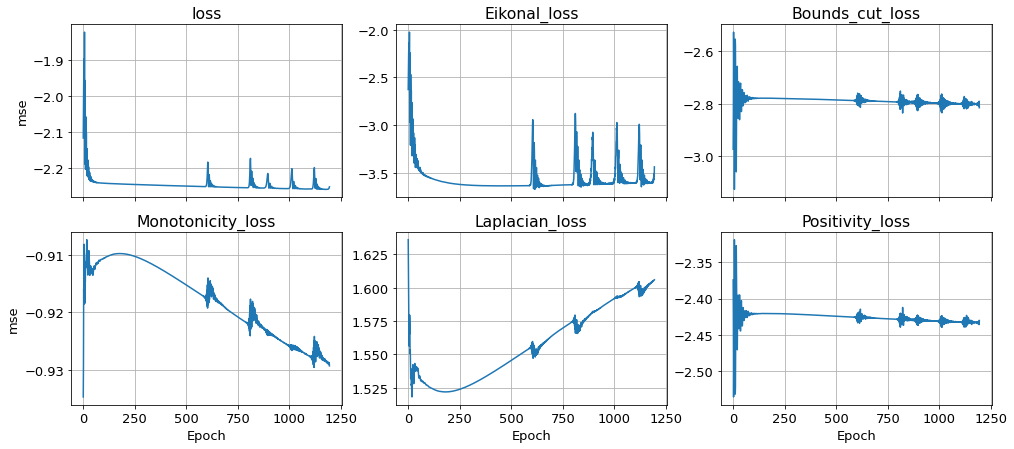

KeyboardInterrupt: 

In [22]:
%%time
input_test = data_inhomo
T_true = T
data_train = data
K = len(data)
epochs = np.linspace(1600, 1000, K, dtype=int)

for i in range(0, K):
    input_train = data[i]
    batch_size = np.size(input_train['input_x'])
    clear_output(wait=True)
    
    H = MODEL.fit(
        x=input_train,
        batch_size=batch_size,
        epochs=epochs[i],
        shuffle=False,
        validation_split=.0,
        verbose=0,
        callbacks=[plmlosses],
        sample_weight=data[i]['weights'].ravel(),
    )
    
    T_pred = outs['T'].predict(input_test) / V.max() * scaler
    T_pred_2d = T_pred.reshape(T_true.shape)
#     T_pred_2d -= T_pred_2d[ixs, izs]
    
    MAE = abs(T_pred_2d - T_true)
    rMAE = MAE / (T_true + 1e-16) * 100
    if rMAE[ixs, izs] != 0.0:
        rMAE[ixs, izs] = 100
    
    eik = outs['E'].predict(input_test).reshape(T_true.shape)
    eik_r = abs(eik) * V_scaled**2 * 100
    dot_term = outs['M'].predict(input_test).reshape(T_true.shape)
    laplacian = outs['L'].predict(input_test).reshape(T_true.shape)
    bounds = outs['B'].predict(input_test).reshape(T_true.shape) / V.max() * scaler
    print('Cycle step:', i)
    print('Batch size:', batch_size)
    print('MAE = {0:.3f} ms, {1:.2f} %'.format(MAE.mean() * 1000, rMAE.mean()))
    fig, axes = plot_utils.plot_images(imgs=[[T_true.T, T_pred_2d.T, MAE.T, None], [eik_r.T, dot_term.T, laplacian.T, bounds.T]], 
                            cols_names=[['True solution', 'Epochs = {}\nANN solution'.format(epochs[i]), 'Residual'], 
                                         ['Eikonal, mean {0:.2f}'.format(eik_r.mean()), 'Monotonicity term', 'Laplacian', 'Bounds']], 
                            sources=[[sou, sou, sou], [None]], extent=(xmin,xmax,zmin,zmax), source_size=10, figsize = (40, 20),  
                            fontsize=13, imshows=False, colorbars=True)
    
#     for j in [1,]:
#         axes[0,j].plot(np.take(x, indices_f[i])[:,0], np.take(z, indices_f[i])[:,1], '.k')
#         axes[0,j].plot(sou[0], sou[1], '*r', ms=10)
    

    plt.show()
    time.sleep(5)

In [82]:
kw = list(H.history.keys())
losses = [H.history[k] for k in kw]
ep = H.epoch

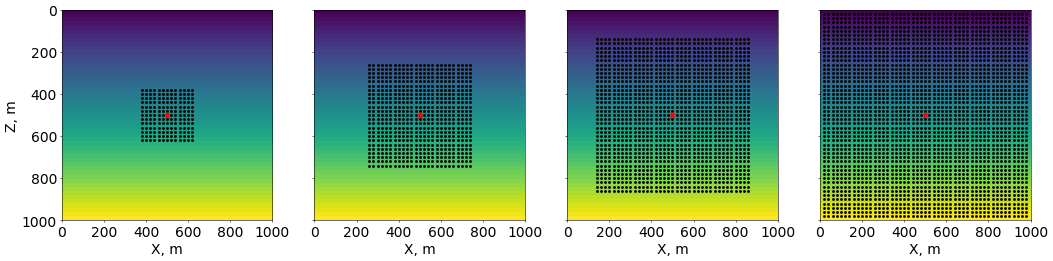

In [35]:
data, indices = eikonal.expansion_batches(arrays=[X_scaled, Z_scaled, V_scaled, B], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'],
                                  center=(ixs, izs), step_i=6, step_j=6, start=1, enhance=False, freq=1)

fig, axes = plot_utils.plot_images(imgs=[[V.T, V.T, V.T, V.T]], cols_names=None, sources=None,
                                   extent=(xmin,xmax,zmin,zmax), source_size=10, figsize = (25, 15),  
                                   fontsize=20, imshows=True, colorbars=False)

for j in [0,1,2,3]:
    axes[0,j].plot(np.take(x, indices[j])[:,0], np.take(z, indices[j])[:,1], '.k')
    axes[0,j].plot(sou[0], sou[1], '*r', ms=10)

In [55]:
model_E.get_weights()[-1][0]*V.max()

array([2685.4763], dtype=float32)

In [ ]:
%%time

input_train = data_r
output_train = data_r['bounds']

input_test = data_inhomo
T_true = T

start, end = 0, 100
epochs = 200
for i in range(start, end):
    
    model_eikonal.fit(
        input_train, 
        output_train, 
        batch_size=len(output_train),
        epochs=epochs,
        shuffle=False,
        validation_split=.0,
        verbose=0,
#         callbacks=[plot_losses]
    )
    
    clear_output(wait=True)
    T_pred = model_t.predict(input_test) / V.max() * scaler
    T_pred_2d = T_pred.reshape(T_true.shape)
#     T_pred_2d -= T_pred_2d[ixs, izs]

    MAE = abs(T_pred_2d - T_true)
    rMAE = MAE / (T_true + 1e-16) * 100
    if rMAE[ixs, izs] != 0.0:
        rMAE[ixs, izs] = 100
    
    eik = model_eikonal.predict(input_test).reshape(T_true.shape)
    eik_r = abs(eik) * V_scaled**2 * 100
    dot_term = model_dot_term.predict(input_test).reshape(T_true.shape)
    laplacian = model_laplacian.predict(input_test).reshape(T_true.shape)
    
    print('MAE = {0:.3f} ms, {1:.2f} %'.format(MAE.mean() * 1000, rMAE.mean()))
    fig, axes = plot_utils.plot_images(imgs=[[T_true.T, T_pred_2d.T, MAE.T], [eik_r.T, dot_term.T, laplacian.T]], 
                            cols_names=[['True solution', 'Epochs = {}\nANN solution'.format(epochs*(i+1-start)), 'Residual'], 
                                         ['Eikonal, mean {0:.2f}'.format(eik_r.mean()), 'Monotonicity term', 'Laplacian']], 
                            sources=[[sou, None, sou], [None]], extent=(xmin,xmax,zmin,zmax), source_size=10, figsize = (30, 20),  
                            fontsize=20, imshows=False, colorbars=True)
    

    plt.show()

In [ ]:
N = 25
plt.figure(figsize=(12,6))
plt.plot(T_true[:,N], '-*r', label='True')
plt.plot(T_pred_2d[:,N])
plt.legend(loc='best')
plt.show()

In [ ]:
model_t.save('../nn_models/model_t_EBM')
model_eikonal.save('../nn_models/model_eikonal_EBM')
model_vectorfield.save('../nn_models/model_vectorfield_EBM')

In [20]:
def divergence(F, dx, dz):
    dF_dx = np.gradient(F[..., 0], dx, dz)[0]
    dF_dz = np.gradient(F[..., 1], dx, dz)[1]
    return dF_dx + dF_dz

def mixed(F, dx, dz):
    dF_dz = np.gradient(F[..., 0], dx, dz)[1]
    dF_dx = np.gradient(F[..., 1], dx, dz)[0]
    return dF_dz, dF_dx

def rotor(F, dx, dz):
    dF_dz, dF_dx = mixed(F, dx, dz)
    return dF_dz - dF_dx

In [21]:
tau_grad = eikonal.t_vfield_vgrad(X, Z, xs, zs, vmin, a)
tau_laplace = divergence(tau_grad, dx, dz)

pred_laplacian = model_L.predict(input_test).reshape(T_true.shape)

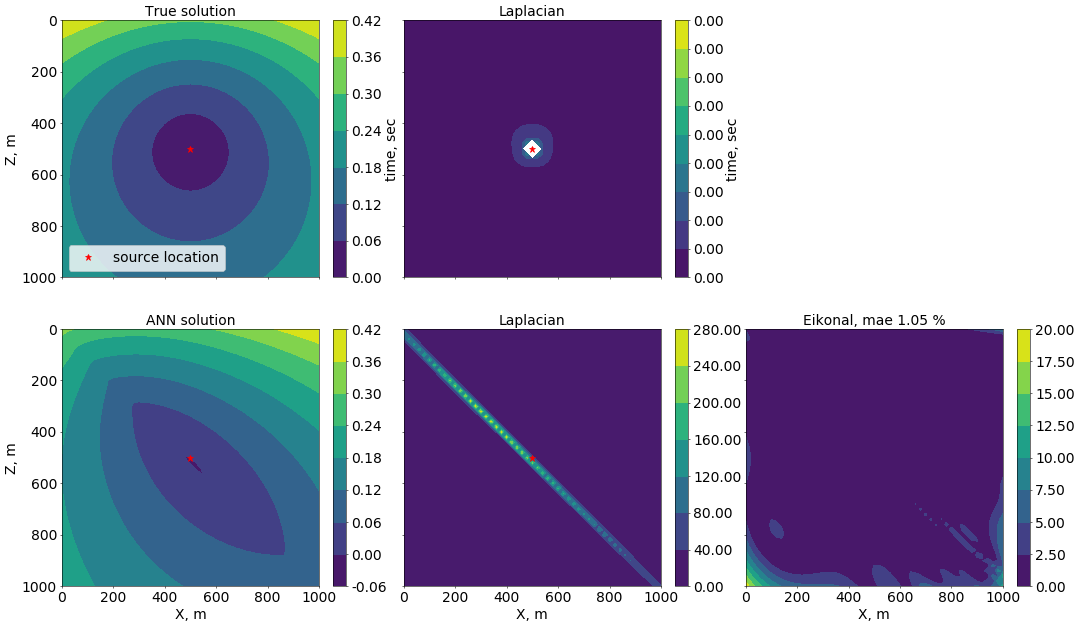

In [28]:
fig, axes = plot_utils.plot_images(imgs=[[T.T, tau_laplace.T, None], [T_pred_2d.T, pred_laplacian.T, eik_r.T]], 
                            cols_names=[['True solution', 'Laplacian'], 
                                         ['ANN solution', 'Laplacian', 'Eikonal, mae {0:.2f} %'.format(eik_r.mean())]], 
                            sources=[[sou, sou], [sou, sou]], extent=(xmin,xmax,zmin,zmax), 
                            source_size=10, figsize = (25, 15),
                            cbar_labels=[['time, sec', 'time, sec']],
                            fontsize=20, colorbars=True, imshows=False)

In [ ]:
plt.contourf(pred_grad[..., 1].T)
# plt.contourf(tau_grad[...,1].T)
plt.colorbar()
plt.show()

## Grid search for $\lambda_{2,3}$

In [ ]:
import pandas as pd

In [ ]:
data, indices = expansion_batches(arrays=[X_scaled, Z_scaled, V_scaled, B], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'],
                                  center=(ixs, izs), step_i=1, step_j=1, start=1)

In [ ]:
columns = ['TEST_NUMBER', 'LAMBDA_2', 'LAMBDA_3', 'MAE', 'RMAE', 'TRAIN_TIME']
model_path = '../nn_models/grid_search/'
data_path = '../data/eikonal_grid_search.xlsx'
df = pd.DataFrame(columns=columns)

In [ ]:
lambda_2 = [0.0]
lambda_3 = [0.2, 0.4, 0.6, 0.8, 1.0]
m = 5
n = len(lambda_2) * len(lambda_3) * m

input_test = data_inhomo
T_true = data_inhomo['true']
epochs = np.linspace(2500, 250, len(data), dtype=int)

with tqdm_notebook(total=n) as p_bar:
    for l2 in lambda_2:
        for l3 in lambda_3:
            for j in range(m):
                m1, m2, m3 = eikonal.init_model(
                            nh=50, layers=3, shape=(1,), activation='tanh', 
                            lr=5e-4, decay=-1e-5, init='glorot_normal', 
                            include_velocity=False, blambda1=1.0, blambda2=l2, blambda3=0.0, 
                            monotonity_dxy=True, monotonity_drdxy=False, mlambda1=l3, mlambda2=0.0)
                
                tic = timeit.default_timer()
                for i in range(0, len(data)):
                    input_train = data[i]
                    output_train = data[i]['bounds']
                    batch_size = len(output_train)


                    m2.fit(
                        input_train, 
                        output_train, 
                        batch_size=batch_size,
                        epochs=epochs[i],
                        shuffle=True,
                        verbose=0
                        )
                toc = timeit.default_timer()
                time = toc - tic
                    
                T_pred = m1.predict(input_test) / V.max() * scaler
                T_pred_2d = T_pred.reshape(T_true.shape)
                MAE = abs(T_pred_2d - T_true)
                rMAE = MAE / (T_true + 1e-16) * 100
                if rMAE[ixs, izs] != 0.0:
                    rMAE[ixs, izs] = 100
                    
                print('MAE = {0:.3f} ms, {1:.3f} %'.format(MAE.mean() * 1000, rMAE.mean()))
                
                d = [j, l2, l3, MAE.mean(), rMAE.mean(), time]
                di = {kw:v for kw, v in zip(columns, d)}
                df = df.append(di, ignore_index=True)
                
                m1.save(model_path + 'm1_{0:.1f}_{1:.1f}_{2}'.format(l2,l3,j))
                m2.save(model_path + 'm2_{0:.1f}_{1:.1f}_{2}'.format(l2,l3,j))
                m3.save(model_path + 'm3_{0:.1f}_{1:.1f}_{2}'.format(l2,l3,j))
                
                p_bar.update()

df.to_excel(data_path)

In [ ]:
lambda_2 = [0.2, 0.4, 0.6, 0.8, 1.0]
lambda_3 = [0.2, 0.4, 0.6, 0.8, 1.0]
m = 5
n = len(lambda_2) * len(lambda_3) * m

input_test = data_inhomo
T_true = data_inhomo['true']
epochs = np.linspace(2500, 250, len(data), dtype=int)

with tqdm_notebook(total=n) as p_bar:
    for l2 in lambda_2:
        for l3 in lambda_3:
            for j in range(m):
                try:
                    m1 = keras.models.load_model(model_path + 'm1_{0:.1f}_{1:.1f}_{2}'.format(l2,l3,j), compile=False)
                except:
                    break
                T_pred = m1.predict(input_test) / V.max() * scaler
                T_pred_2d = T_pred.reshape(T_true.shape)
                MAE = abs(T_pred_2d - T_true)
                rMAE = MAE / (T_true + 1e-16) * 100
                if rMAE[ixs, izs] != 0.0:
                    rMAE[ixs, izs] = 100
                    
                print('MAE = {0:.3f} ms, {1:.3f} %'.format(MAE.mean() * 1000, rMAE.mean()))
                time = 0.0
                d = [j, l2, l3, MAE.mean(), rMAE.mean(), time]
                di = {kw:v for kw, v in zip(columns, d)}
                df = df.append(di, ignore_index=True)
                
                p_bar.update()

# df.to_excel(data_path)

In [ ]:
(df.RMAE < 8).index

In [ ]:
df.loc[df.RMAE < 8.0].groupby(['LAMBDA_2']).mean()

In [ ]:
tau_grad = t_vfield_vgrad(X, Z, xs, zs, vmin, a)
tau_modul = np.linalg.norm(tau_grad, axis=-1, keepdims=True) + 1e-16
tau_grad_norm = tau_grad / tau_modul

pred_grad = model_vectorfield.predict(input_test) / V.max()
pred_grad = pred_grad.reshape(T_pred_2d.shape + (2,))
pred_modul = np.linalg.norm(pred_grad, axis=-1, keepdims=True) + 1e-16
pred_grad_norm = pred_grad / pred_modul

diff_grad = np.linalg.norm(tau_grad - pred_grad, axis=-1)
r_diff_grad = diff_grad / tau_modul.squeeze() * 100

step = 2

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_1 = tau_grad_norm[::step, ::step, 0]
V_1 = -tau_grad_norm[::step, ::step, 1]

U_2 = pred_grad_norm[::step, ::step, 0]
V_2 = -pred_grad_norm[::step, ::step, 1]

In [ ]:
extent = (x.min(), x.max(), z.min(), z.max())

mae = abs(tau - T_pred_2d) / tau * 100
mae[ixs, izs] = 0
# mae2 = abs(tau - result[1]) / (tau + 1e-16) * 100

fsm = FSM[ixs,izs]
fsm_mae = abs(tau - fsm) / (tau + 1e-16) * 100

imgs = [[tau.T * 1000, fsm.T * 1000, fsm_mae.T], 
        [tau.T * 1000, T_pred_2d.T * 1000, mae.T]]

cols_names = [['Аналитическое решение', 'Решение FSM', 'Относительна ошибка, mae {0:.2f} %'.format(fsm_mae.mean())], 
              ['Аналитическое решение', 'Решение нейронной сети', 'Относительна ошибка, mae {0:.2f} %'.format(mae.mean())]]

imshows = False
colorbars = [[True, True, True], 
             [True, True, True], 
             [True, True, True]]
cbar_labels = [['время, мс', 'время, мс', 'ошибка, %'], 
               ['время, мс', 'время, мс', 'ошибка, %']]

sources = [[sou, sou, sou],[sou, sou, sou]]
source_label = 'положение источника'

fig, axes = plot_utils.plot_images(imgs=imgs, cols_names=cols_names, imshows=imshows, colorbars=colorbars, cbar_labels=cbar_labels,
                        figsize=(25,14), extent=extent, sources=sources, source_label=source_label,
                        source_size=12)

plt.show()

In [ ]:
N = 13
plt.figure(figsize=(12,6))
plt.plot(T_true[:,N], '-*r', label='True')
plt.plot(T_pred_2d[:,N])
plt.legend(loc='best')
plt.show()

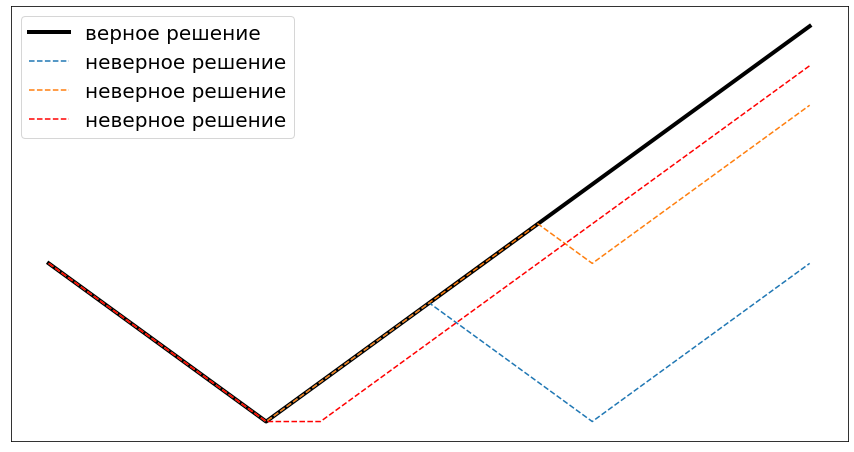

In [74]:
r = np.linspace(0, 10, 15)
p1 = abs(r - r[4])
p2 = abs(r - r[10])
p3 = abs(r - r[10]) + r[4]
p4 = abs(r - r[5])
p2m = np.array([p1, p2]).min(axis=0)
p3m = np.array([p1, p3]).min(axis=0)
p4m = np.array([p1, p4]).min(axis=0)

plt.figure(figsize=(15,8))
plt.plot(r, p1, 'k', lw=4, label='верное решение')
plt.plot(r, p2m, '--', label='неверное решение')
plt.plot(r, p3m, '--', label='неверное решение')
plt.plot(r, p4m, '--r', label='неверное решение')
plt.legend(loc='upper left')
plt.xticks([])
plt.yticks([])
plt.show()

## All tests with layers and local anomalies

In [12]:
model_layers_high = keras.models.load_model('../../nn_models/eikonal/model_t_layers_high', compile=False)
model_layers_low = keras.models.load_model('../../nn_models/eikonal/model_t_layers_low', compile=False)
model_local_high = keras.models.load_model('../../nn_models/eikonal/model_t_local_high', compile=False)
model_local_low = keras.models.load_model('../../nn_models/eikonal/model_t_local_low', compile=False)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
nx, nz = 51, 51
xmin, xmax = 0, 1000
zmin, zmax = 0, 1000
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
dx, dz = x[1] - x[0], z[1] - z[0]
X, Z = np.meshgrid(x, z, indexing='ij')

ixs, izs = 10, 10
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler

In [14]:
vmin, vmax = 2000.0, 3000.0
izc = 25
V_layers_high = np.full_like(Z, vmin)
V_layers_high[:, izc:] = vmax
V_layers_low = np.full_like(Z, vmax)
V_layers_low[:, izc:] = vmin

T_true_layers_high = eikonal.get_time_layered(vmin, vmax, izc, X, Z, ixs, izs)
T_true_layers_low = eikonal.get_time_layered(vmax, vmin, izc, X, Z, ixs, izs)

In [15]:
vmin, vmax = 1000.0, 3000.0
ixc, izc = 30, 30
V_local_high = eikonal.gaussian(X, Z, ixc, izc, vmin, vmax, 100.0, 100.0)
V_local_low = eikonal.gaussian(X, Z, ixc, izc, vmax, vmin, 100.0, 100.0)

In [16]:
data_inhomo = eikonal.prepare_inputs([X_scaled.ravel(), Z_scaled.ravel(), V_local_high.ravel()], 
                             ['input_x', 'input_y', 'velocity'])

In [17]:
T_pred_local_high = model_local_high.predict(data_inhomo).reshape(X.shape) / V_local_high.max() * scaler
T_pred_local_high -= T_pred_local_high[ixs, izs]
T_pred_local_low = model_local_low.predict(data_inhomo).reshape(X.shape) / V_local_low.max() * scaler
T_pred_local_low -= T_pred_local_low[ixs, izs]

T_pred_layers_high = model_layers_high.predict(data_inhomo).reshape(X.shape) / V_layers_high.max() * scaler
T_pred_layers_high -= T_pred_layers_high[ixs, izs]
T_pred_layers_low = model_layers_low.predict(data_inhomo).reshape(X.shape) / V_layers_low.max() * scaler
T_pred_layers_low -= T_pred_layers_low[ixs, izs]

In [20]:
T_fsm_local_high = np.load('../../data/fsm_local_high.npy')
T_fsm_local_low = np.load('../../data/fsm_local_low.npy')

In [21]:
T_all_true = [T_fsm_local_high, T_true_layers_high, T_true_layers_low]
T_all_pred = [T_pred_local_high, T_pred_layers_high, T_pred_layers_low]

In [22]:
%matplotlib inline

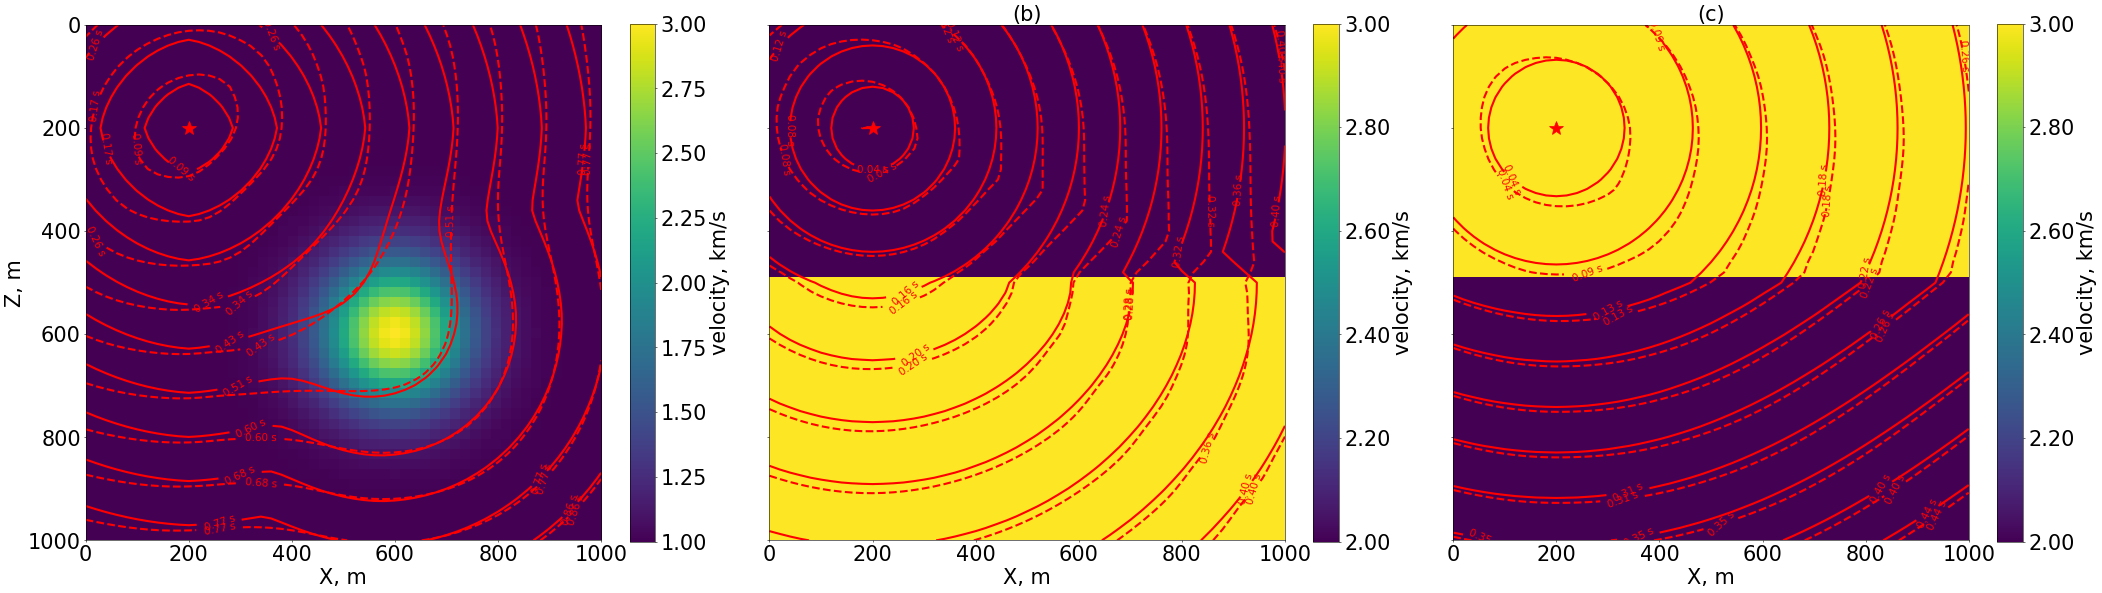

In [27]:
sources = [[sou, sou, sou, sou]]
names = [['(a)', '(b)', '(c)', '(d)']]
imshows = True
extent = (xmin, xmax, zmin, zmax)
colorbars = True
cbar_labels = [['velocity, km/s']*4]
source_size = 12
fontsize = 30
figsize = (50,40)
legend = False

fig, axes = plot_utils.plot_images(imgs=[[V_local_high.T/1000, V_layers_high.T/1000, V_layers_low.T/1000]], 
                                   cols_names=names, sources=None, imshows=imshows, extent=extent, source_size=source_size,
                                  figsize=figsize, fontsize=fontsize, colorbars=colorbars, cbar_labels=cbar_labels, legend=legend,
                                  )

for i, (t1, t2) in enumerate(zip(T_all_true, T_all_pred)):
    levels = np.linspace(0, t1.max(), 12)
    
    cs = axes[0,i].contour(t1.T, levels=levels, colors='r', linewidths=3, extent=extent)
    axes[0,i].clabel(cs, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=15)
    cs = axes[0,i].contour(t2.T, levels=levels, colors='r', linewidths=3, linestyles='--', extent=extent)
    axes[0,i].clabel(cs, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=15)
    axes[0,i].plot(sou[0], sou[1], 'r*', ms=20, label='source')

plt.show()

In [ ]:
def mae_rmae(T1, T2):
    AE = abs(T1 - T2)
    MAE = AE.mean()
    rMAE = (AE / (T2 + 1e-16) * 100).mean()
    return MAE, rMAE

In [ ]:
for t1, t2 in zip(T_all_true, T_all_pred):
    AE = abs(t1 - t2)
    MAE = AE.mean()
    rMAE = (AE / (t1 + 1e-16) * 100).mean()
    print(MAE * 1000, rMAE)

## Sketch for vertical gradient (EB, EBP, EBM, EBPM)

In [ ]:
model_EB = keras.models.load_model('../nn_models/model_t_EB', compile=False)
model_EBP = keras.models.load_model('../nn_models/model_t_EBP', compile=False)
model_EBM = keras.models.load_model('../nn_models/model_t', compile=False)
model_EBPM = keras.models.load_model('../nn_models/model_t_EBPM', compile=False)

In [ ]:
nx, nz = 51, 51
xmin, xmax = 0, 1000
zmin, zmax = 0, 1000
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
dx, dz = x[1] - x[0], z[1] - z[0]
X, Z = np.meshgrid(x, z, indexing='ij')

ixs, izs = 25, 25
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler

In [ ]:
data_inhomo = eikonal.prepare_inputs([X_scaled.ravel(), Z_scaled.ravel(), V_scaled.ravel()], 
                             ['input_x', 'input_y', 'velocity'])

In [ ]:
T_pred_EB = model_EB.predict(data_inhomo).reshape(X.shape) / V.max() * scaler
T_pred_EB -= T_pred_EB[ixs, izs]
T_pred_EBP = model_EBP.predict(data_inhomo).reshape(X.shape) / V.max() * scaler
# T_pred_EBP -= T_pred_EBP[ixs, izs]
T_pred_EBM = model_EBM.predict(data_inhomo).reshape(X.shape) / V.max() * scaler
T_pred_EBM -= T_pred_EBM[ixs, izs]
T_pred_EBPM = model_EBPM.predict(data_inhomo).reshape(X.shape) / V.max() * scaler
T_pred_EBPM -= T_pred_EBPM[ixs, izs]

In [ ]:
T_all_pred = [T_pred_EB, T_pred_EBP, T_pred_EBM]

In [ ]:
sources = [[sou, sou, sou, sou]]
names = [['(a)', '(b)', '(c)', '(d)']]
imshows = True
extent = (xmin, xmax, zmin, zmax)
colorbars = True
cbar_labels = [['velocity, km/s']*4]
source_size = 12
fontsize = 22
figsize = (33,22)
legend = True

fig, axes = plot_utils.plot_images(imgs=[[V.T/1000, V.T/1000, V.T/1000]], 
                                   cols_names=names, sources=None, imshows=imshows, extent=extent, source_size=source_size,
                                  figsize=figsize, fontsize=fontsize, colorbars=colorbars, cbar_labels=cbar_labels, legend=legend,
                                  )

for i, t in enumerate(T_all_pred):
    levels = np.linspace(0, T.max(), 9)
    levels2 = np.hstack((-levels[::-1][:-1], levels))
    
    cs = axes[0,i].contour(T.T, levels=levels, colors='r', linewidths=2, extent=extent)
    axes[0,i].clabel(cs, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=15)
    cs = axes[0,i].contour(t.T, levels=levels2, colors='r', linewidths=2, linestyles='--', extent=extent)
    axes[0,i].clabel(cs, levels2, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=15)
    axes[0,i].plot(sou[0], sou[1], 'r*', ms=15, label='source')
axes[0,0].legend(loc='lower left')
    
plt.show()

In [ ]:
AE = abs(T_pred_EBM - T)
MAE = AE.mean()
rMAE = (AE / (T + 1e-16) * 100).mean()
MAE, rMAE